In [9]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
%pip install umap-learn
import umap
%pip install hdbscan
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load in the test data.

In [16]:
sub1test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-001_Resp_Test.npy")
sub2test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-002_Resp_Test.npy")
sub3test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-003_Resp_Test.npy")
sub4test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-004_Resp_Test.npy")
sub5test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-005_Resp_Test.npy")
print(sub1test.shape)
print(sub2test.shape)
print(sub3test.shape)
print(sub4test.shape)
print(sub5test.shape)

(60784, 4, 600)
(53927, 4, 600)
(64700, 4, 600)
(61899, 4, 600)
(53421, 4, 600)


Concatenate all of the data.

In [23]:
# Each element should be a NumPy array of shape [n_voxels, 4, 60]
subject_list = [sub1test, sub2test, sub3test, sub4test, sub5test]

In [29]:
all_subjects_data = []       # list of [240, n_voxels] per subject
all_genre_labels = []        # genre_labels_named per subject
all_subject_ids = []         # subject index per sample

Create a genre label vector to feed into the UMAP function.

In [ ]:
import scipy.io as sio
import numpy as np

# Load the .mat file (adjust the path if needed)
data = sio.loadmat('/Users/jenniferarakaki/Documents/neuro120/8275363/AcrossGenre_Order_Test.mat')
test_run_data = data['across_genre_rn_test']  # shape: (6 runs, 4 reps, 10 genres)

# Step 1: Extract the genre label for each of the 60 tracks (6 runs × 10 tracks)
# We use repetition 0 because all 4 reps use the same tracks
genre_labels = []

for run in range(6):  # 6 runs
    for track_position in range(10):  # 10 tracks per run
        genre_id = int(test_run_data[run, 0, track_position])  # genre labels are 1-indexed (1–10)
        genre_labels.append(genre_id)

# Step 2: Repeat each genre label 4 times (one for each repetition)
genre_labels_full = np.repeat(genre_labels, 4)  # shape: (240,)

In [28]:
# Optional: convert genre numbers to names for visualization
genre_names = ['classical', 'electronic', 'folk', 'hiphop', 'jazz',
               'metal', 'pop', 'punk', 'rock', 'world']
genre_labels_named = [genre_names[i - 1] for i in genre_labels_full]

# Preview the result
print(genre_labels_named[:12])  # First 3 tracks (4 reps each)
print(len(genre_labels_named)) 

['world', 'world', 'world', 'world', 'folk', 'folk', 'folk', 'folk', 'classical', 'classical', 'classical', 'classical']
240


PCA dimension reduction so we can stack the voxel info from the different subjects without getting errors about differently sized vectors:

In [58]:
from sklearn.decomposition import PCA
import numpy as np

all_subjects_pca = []
all_genre_labels = []
all_subject_ids = []

for subject_idx, fmri_data in enumerate(subject_list):
    subject_samples = []
    
    for track_idx in range(60):
        for rep in range(4):
            t = track_idx * 10 + 8
            voxel_vector = fmri_data[:, rep, t]
            subject_samples.append(voxel_vector)

    subject_samples = np.stack(subject_samples)  # shape: [240, n_voxels]

    # Subject-wise PCA (to handle voxel count mismatch)
    pca = PCA(n_components=100)
    subject_pca = pca.fit_transform(subject_samples)  # shape: [240, 100]

    all_subjects_pca.append(subject_pca)
    all_genre_labels.extend(genre_labels_named)  # same 240 for each subject
    all_subject_ids.extend([subject_idx] * 240)

# Final combined matrix
data_matrix = np.vstack(all_subjects_pca)  # shape: [1200, 100]



In [61]:
data_matrix.shape
import numpy as np
genre_labels_named_all = np.tile(genre_labels_named, 5)  # shape: (1200,)

print(data_matrix.shape)               # should be (1200, ...)
print(len(genre_labels_named_all))     # 1200
print(len(all_subject_ids))            # 1200
print(genre_labels_named_all[:12])     # should show 3 tracks × 4 reps


(1200, 100)
1200
1200
['world' 'world' 'world' 'world' 'folk' 'folk' 'folk' 'folk' 'classical'
 'classical' 'classical' 'classical']


Put the above into UMAP:

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


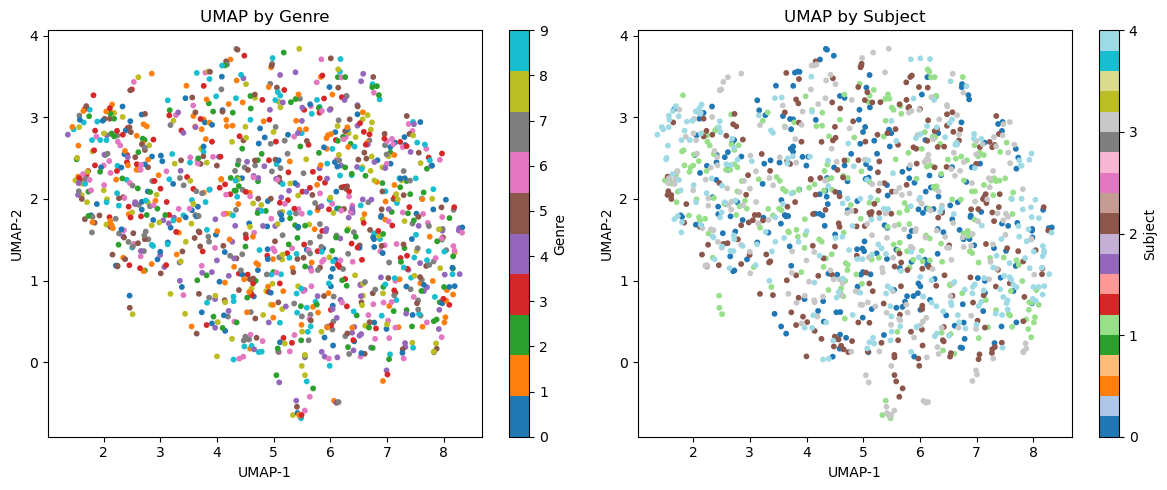

In [62]:
# --- Step 1: UMAP from 100D → 2D ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(data_matrix)  # shape: [n_samples, 2]

# --- Step 2: Encode labels ---
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_all)

# --- Step 3: Plotting ---
plt.figure(figsize=(12, 5))

# -- Plot by Genre --
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(embedding[:, 0], embedding[:, 1], c=genre_encoded, cmap='tab10', s=10)
plt.title("UMAP by Genre")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter1, ticks=range(10), label='Genre')

# -- Plot by Subject --
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(embedding[:, 0], embedding[:, 1], c=subject_ids, cmap='tab20', s=10)
plt.title("UMAP by Subject")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter2, ticks=range(len(np.unique(subject_ids))), label='Subject')

plt.tight_layout()
plt.show()

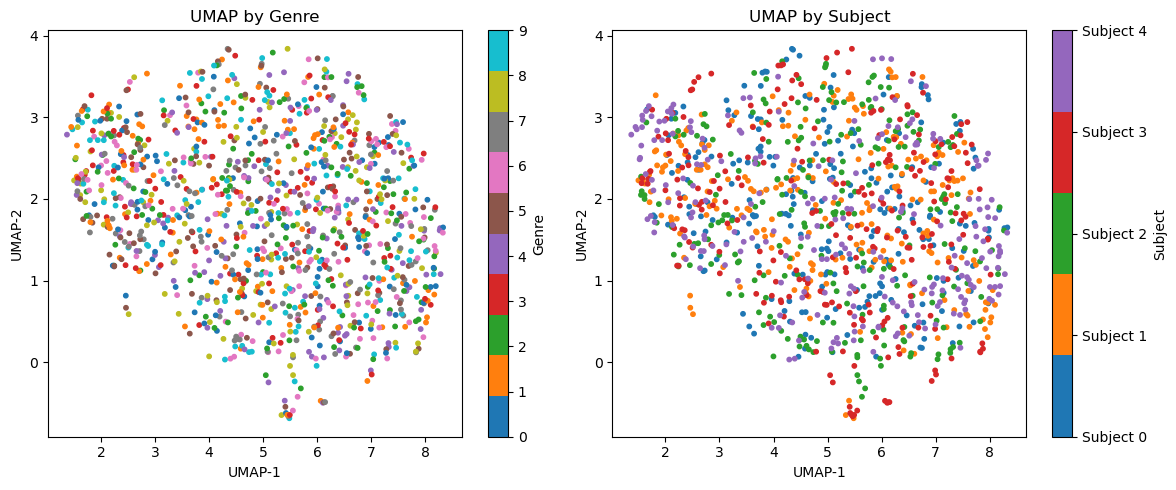

In [63]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# --- Step 1: Encode genre labels ---
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_all)

# --- Step 2: Create custom colormap for 5 subjects ---
subject_cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# --- Step 3: Plot both genre and subject ---
plt.figure(figsize=(12, 5))

# -- Plot by Genre --
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(embedding[:, 0], embedding[:, 1], c=genre_encoded, cmap='tab10', s=10)
plt.title("UMAP by Genre")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cbar1 = plt.colorbar(scatter1, ticks=range(10))
cbar1.set_label("Genre")

# -- Plot by Subject (with fixed 5-color map) --
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(embedding[:, 0], embedding[:, 1], c=subject_ids, cmap=subject_cmap, s=10)
plt.title("UMAP by Subject")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cbar2 = plt.colorbar(scatter2, ticks=range(5))
cbar2.set_label("Subject")
cbar2.set_ticklabels([f"Subject {i}" for i in range(5)])

plt.tight_layout()
plt.show()



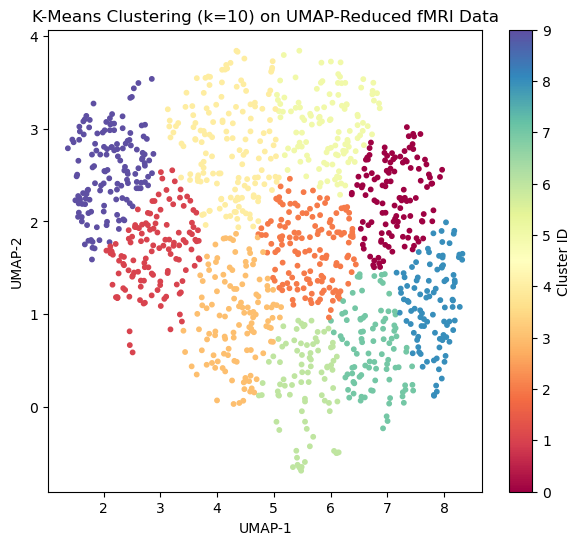

In [64]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Run KMeans on your UMAP embedding (2D)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(embedding)  # embedding: [n_samples, 2]

# Step 2: Visualize clusters
plt.figure(figsize=(7, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, cmap='Spectral', s=10)
plt.title("K-Means Clustering (k=10) on UMAP-Reduced fMRI Data")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster ID")
plt.show()


In [66]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ari = adjusted_rand_score(genre_labels_named_all, kmeans_labels)
ami = adjusted_mutual_info_score(genre_labels_named_all, kmeans_labels)

print(f"ARI: {ari:.3f} | AMI: {ami:.3f}")


ARI: 0.000 | AMI: 0.000


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


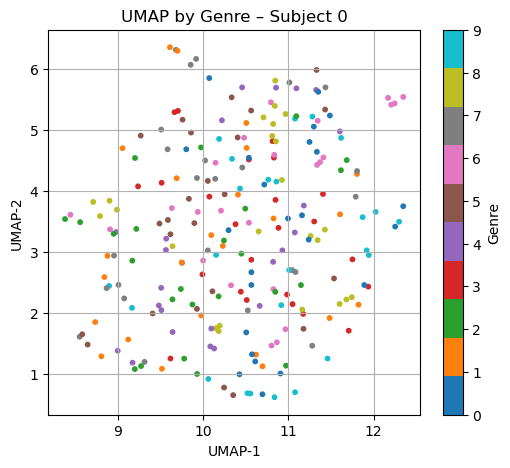

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


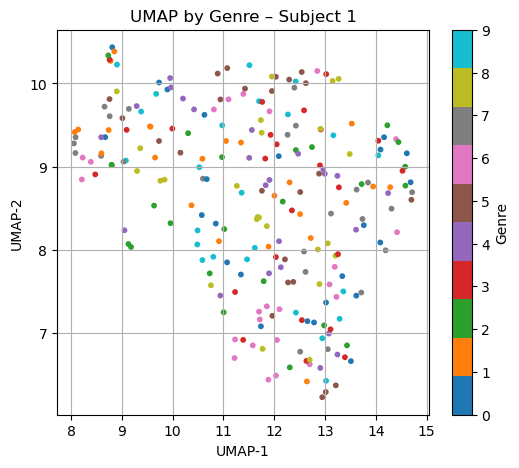

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


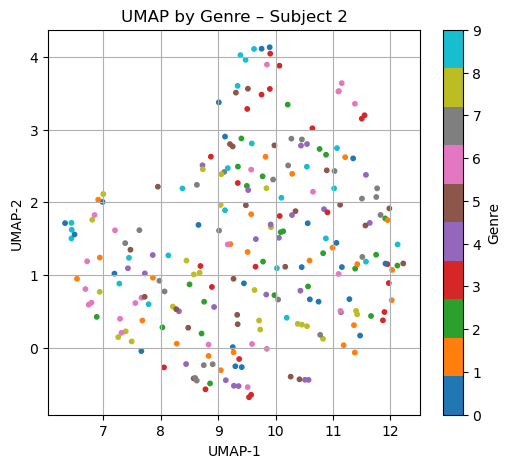

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


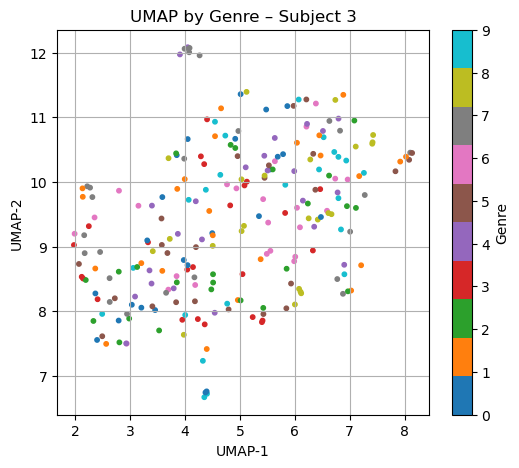

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


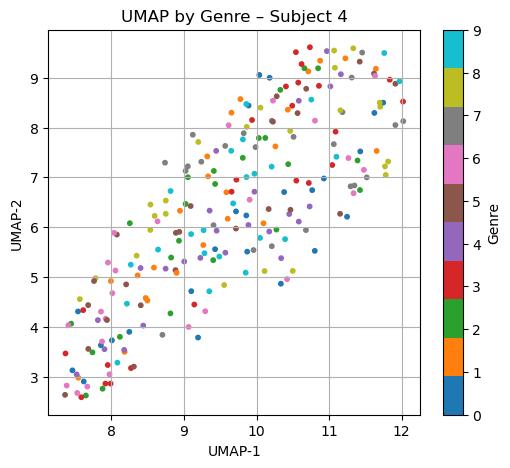

In [67]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Already have:
# genre_labels_named → shape [240]
# subject_list → list of 5 arrays, each [n_voxels, 4, 600]

genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named)

for subject_idx, fmri_data in enumerate(subject_list):
    # Step 1: Extract voxel vectors for this subject
    samples = []
    for rep in range(4):
        for track_idx in range(60):
            t = track_idx * 10 + 8
            voxel_vector = fmri_data[:, rep, t]
            samples.append(voxel_vector)

    data_matrix = np.stack(samples)  # shape: [240, n_voxels]

    # Step 2: UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(data_matrix)

    # Step 3: Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=genre_encoded, cmap='tab10', s=10)
    plt.title(f"UMAP by Genre – Subject {subject_idx}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    cbar = plt.colorbar(ticks=range(10))
    cbar.set_label("Genre")
    plt.grid(True)
    plt.show()


In [45]:
for run in range(6):
    for genre_slot in range(10):
        genre_id = test_run_data[run, 0, genre_slot]


['world', 'world', 'world', 'world', 'folk', 'folk', 'folk', 'folk', 'classical', 'classical']
['classical', 'classical', 'hiphop', 'hiphop', 'hiphop', 'hiphop', 'pop', 'pop', 'pop', 'pop']
['rock', 'rock', 'rock', 'rock', 'electronic', 'electronic', 'electronic', 'electronic', 'jazz', 'jazz']
['jazz', 'jazz', 'metal', 'metal', 'metal', 'metal', 'punk', 'punk', 'punk', 'punk']
['rock', 'rock', 'rock', 'rock', 'world', 'world', 'world', 'world', 'jazz', 'jazz']
['jazz', 'jazz', 'punk', 'punk', 'punk', 'punk', 'folk', 'folk', 'folk', 'folk']


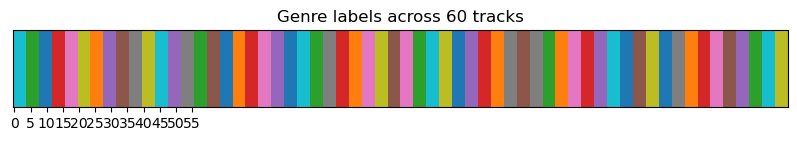

240

In [ ]:
for i in range(6):
    print(genre_labels_named[i*10:(i+1)*10])
    
import matplotlib.pyplot as plt
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named)
plt.figure(figsize=(10, 1))
plt.imshow(genre_encoded.reshape(1, -1), aspect='auto', cmap='tab10')
plt.yticks([])
plt.xticks(range(0, 60, 5))
plt.title("Genre labels across 60 tracks")
plt.show()


In [50]:
for track_idx in range(60):
    for rep in range(4):
        timepoint = track_idx * 10 + 8
        voxel_vector = fmri_data[:, rep, timepoint]


In [53]:
import scipy.io as sio

# Replace the path below with wherever your file is stored
mat_data = sio.loadmat('/Users/jenniferarakaki/Documents/neuro120/8275363/AcrossGenre_Order_Test.mat')

# Extract the variable
across_genre_rn_test = mat_data['across_genre_rn_test']  # shape: (6 runs, 4 reps, 10 genres)


In [54]:
genre_labels = []

for run in range(6):
    for track_pos in range(10):
        genre_id = int(across_genre_rn_test[run, 0, track_pos])
        genre_labels.append(genre_id)

genre_labels_full = np.repeat(genre_labels, 4)  # shape: (240,)


In [55]:
genre_names = ['classical', 'electronic', 'folk', 'hiphop', 'jazz',
               'metal', 'pop', 'punk', 'rock', 'world']
genre_labels_named = [genre_names[i - 1] for i in genre_labels_full]


In [56]:
print(genre_labels_named[:12])
print("Total samples:", len(genre_labels_named))  # should be 240


['world', 'world', 'world', 'world', 'folk', 'folk', 'folk', 'folk', 'classical', 'classical', 'classical', 'classical']
Total samples: 240
